In [1]:
# Install all required libraries using python -m pip (works even if pip not in PATH)
import sys
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!{sys.executable} -m pip install transformers pillow matplotlib numpy -q

Looking in indexes: https://download.pytorch.org/whl/cpu



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Data

In [2]:
import os
import torch
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Data paths - updated to use local segmented_folder
segmented = './segmented_folder'
apple_black_rot = './segmented_folder/Apple___Black_rot'
apple_healthy = './segmented_folder/Apple___healthy'

# Verify the data path exists
if os.path.exists(segmented):
    print(f"✓ Data directory found: {segmented}")
    # Count number of classes
    classes = [d for d in os.listdir(segmented) if os.path.isdir(os.path.join(segmented, d))]
    print(f"✓ Number of classes: {len(classes)}")
    print(f"✓ Classes: {classes[:5]}...")  # Show first 5 classes
else:
    print(f"✗ Data directory not found: {segmented}")
    print("Please ensure the segmented_folder is in the same directory as this notebook.")

✓ Data directory found: ./segmented_folder
✓ Number of classes: 33
✓ Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___healthy']...


In [ ]:
train_transforms =  transforms.Compose([
    transforms.RandomResizedCrop(224),  # Changed from 32 to 224 for ResNet
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 45),
    transforms.ToTensor(),  # Converts PIL Image to tensor and scales to [0, 1]
])

In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize to slightly larger than target
    transforms.CenterCrop(224),  # Crop to 224x224 for ResNet
    transforms.ToTensor(),  # Converts PIL Image to tensor and scales to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
try:
    file = ImageFolder(root = segmented, transform = train_transforms)
    old_file = ImageFolder(root = segmented, transform = val_transforms )
    # file = ImageFolder(root = apple_black_rot)
    # apple_h = ImageFolder(root = apple_healthy)

except FileNotFoundError:
    print("File not found")


# Splitting the dataset

In [6]:
train_size = int(0.8 * len(file))
test_size = int(0.1 * len (file))
valid_size = len(file ) - test_size - train_size

train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(file, [train_size, test_size, valid_size])

BATCH_SIZE = 32

In [7]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)
valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


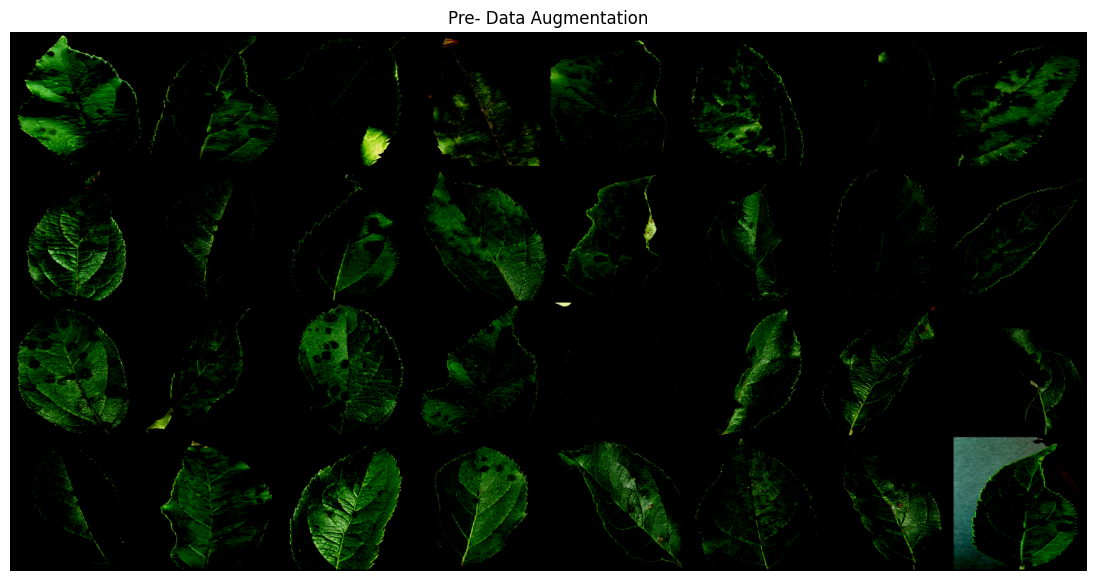

In [8]:
pre_aug =  DataLoader(
    dataset = old_file,
    batch_size = BATCH_SIZE,
    shuffle = False
)
image, label = next(iter(pre_aug))
grid = torchvision.utils.make_grid(image)
plt.figure(figsize=(15, 7))

# Transpose the grid from (C, H, W) to (H, W, C) for matplotlib
plt.imshow(grid.permute(1, 2, 0))

plt.title("Pre- Data Augmentation")
plt.axis('off')
plt.show()

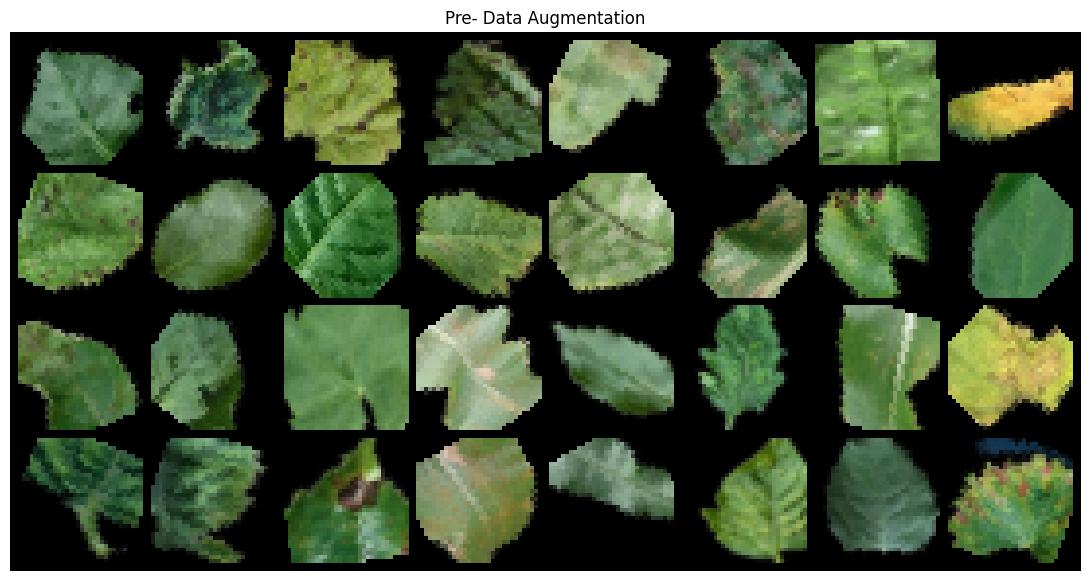

In [9]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

image, label = next(iter(train_loader))
grid = torchvision.utils.make_grid(image)
plt.figure(figsize=(15, 7))

# Transpose the grid from (C, H, W) to (H, W, C) for matplotlib
plt.imshow(grid.permute(1, 2, 0))

plt.title("Pre- Data Augmentation")
plt.axis('off')
plt.show()

# Augmenting Data 
Performing transformations on data helps:
* prevent overfitting
* expands the diversity of dataset
* robust + generalize 

In [10]:
weights = models.MobileNet_V3_Small_Weights.DEFAULT
model = models.mobilenet_v3_small(weights = weights )

# Binary Classification with Hugging Face ResNet

Binary classification: Healthy vs Diseased plants

In [11]:
# Install required libraries for Hugging Face ResNet
import sys
!{sys.executable} -m pip install transformers -q

from transformers import AutoImageProcessor, ResNetForImageClassification
import torch.nn as nn
import torch.optim as optim


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Multiclass Classification Setup
# Using all 33 classes directly from the ImageFolder dataset

# Get number of classes from the dataset
num_classes = len(file.classes)
class_names = file.classes

print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names[:10]}...")  # Show first 10 classes
print(f"\nDataset size: {len(file)}")
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Validation size: {valid_size}")

In [ ]:
# Create data loaders for multiclass classification
# Using the existing train/test/valid splits from cell 7

multiclass_train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

multiclass_test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

multiclass_valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Multiclass train size: {train_size}")
print(f"Multiclass test size: {test_size}")
print(f"Multiclass validation size: {valid_size}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {num_classes}")

In [ ]:
# Load pre-trained ResNet from Hugging Face for Multiclass Classification
model_name = "microsoft/resnet-50"

# Load the image processor for proper preprocessing
# This handles resizing images to the correct size for ResNet
image_processor = AutoImageProcessor.from_pretrained(model_name)
print(f"Image processor loaded: {model_name}")
print(f"Expected image size: {image_processor.size}")

# Load the ResNet model for multiclass classification
resnet_model = ResNetForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,  
    ignore_mismatched_sizes=True
)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

resnet_model = resnet_model.to(device)

print(f"\nModel: {model_name}")
print(f"Number of output classes: {num_classes}")
print(f"Total parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")

In [ ]:
# Cross Entropy Loss for Multiclass Classification
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

print("Loss Function: CrossEntropyLoss")
print("  - Combines LogSoftmax + NLLLoss")
print("  - For multiclass classification with mutually exclusive classes")
print("  - Formula: -log(exp(x_class) / sum(exp(x_j)))")
print(f"\nOptimizer: Adam (lr=0.0001)")
print(f"Criterion: {criterion}")
print(f"Number of classes: {num_classes}")

In [ ]:
# Training function for multiclass classification with loss tracking and weight saving
def train_multiclass_classifier(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, save_path='resnet_weights.pth'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)  # Labels are class indices (0 to num_classes-1)
            
            # Forward pass
            outputs = model(images).logits  # ResNet outputs logits
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            
            # Get predictions (class with highest probability)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}")
        
        # Calculate epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predictions = torch.max(outputs, 1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)
        
        # Print epoch summary (loss tracked after every epoch)
        print(f"\n{'='*60}")
        print(f"EPOCH [{epoch+1}/{num_epochs}] SUMMARY")
        print(f"{'='*60}")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
        print(f"  Val Loss:   {val_epoch_loss:.4f}, Val Acc:   {val_epoch_acc:.2f}%")
        
        # Save best model weights
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_loss,
                'val_loss': val_epoch_loss,
                'train_acc': epoch_acc,
                'val_acc': val_epoch_acc,
                'num_classes': num_classes,
                'class_names': class_names
            }, save_path)
            print(f"  [SAVED] New best model saved to {save_path}")
        
        print(f"{'='*60}\n")
    
    # Save final model weights
    final_save_path = save_path.replace('.pth', '_final.pth')
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'num_classes': num_classes,
        'class_names': class_names
    }, final_save_path)
    print(f"Final model saved to {final_save_path}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train the multiclass classifier
train_losses, val_losses, train_accs, val_accs = train_multiclass_classifier(
    model=resnet_model,
    train_loader=multiclass_train_loader,
    val_loader=multiclass_valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5,
    save_path='resnet_plant_disease_weights.pth'
)

In [ ]:
# Visualize training results - Loss and Accuracy plots
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
epochs = range(1, len(train_losses) + 1)
axes[0].plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss')
axes[0].plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[1].plot(epochs, train_accs, 'b-', linewidth=2, label='Training Accuracy')
axes[1].plot(epochs, val_accs, 'r-', linewidth=2, label='Validation Accuracy')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("=" * 60)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("=" * 60)
print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"\nBest Validation Accuracy: {max(val_accs):.2f}%")
print(f"Number of Classes: {num_classes}")
print(f"\nModel weights saved to:")
print(f"  - resnet_plant_disease_weights.pth (best)")
print(f"  - resnet_plant_disease_weights_final.pth (final)")
print("=" * 60)